In [12]:
import datetime; datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2024-05-16 10:51:52'

In [13]:
import mysql.connector
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import matplotlib.ticker as ticker

%matplotlib inline

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 "grid.color": "lightgrey",
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False,
    })
plt.rcParams["figure.figsize"] = (30,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})
# paper config below (uncomment)

plt.rcParams.update({
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.size': 15,
    'figure.autolayout': True,
    'figure.figsize': (7.2,4.45),
    'axes.titlesize' : 16,
    'axes.labelsize' : 17,
    'lines.linewidth' : 2,
    'lines.markersize' : 6,
    'legend.fontsize': '13',
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',

    })


plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("bright"))
sns.color_palette("bright")
from cycler import cycler

fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.7
lhandle = 2.0
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))
marker_cycler = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["none", "none", "none", "none", "none", "none", "none"]) +
                 cycler(marker=["4", "2", "3", "1", "+", "x", "."]))
standard_cycler = cycler("color", ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"])
plt.rc("axes", prop_cycle=standard_cycler)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]


In [16]:
class DbAccessor:
    def __init__(self, db_name, local=False, rlaidb=False, gc=False, gc2=False):
        try:
            if local:
                    self.conn = mysql.connector.connect(user="haseebs",
                                                password="",
                                                host="localhost",
                                                port=3306,
                                                database=db_name)
            elif rlaidb:
                self.conn = mysql.connector.connect(user='hshah1',
                                            password=os.environ['rlaidbpswd'],
                                            host='198.168.186.104',
                                            database=db_name)

            elif gc:
                self.conn = mysql.connector.connect(user='rlai',
                                            password=os.environ['gcpswd'],
                                            host='35.203.104.151',
                                            database=db_name)
            elif gc2:
                self.conn = mysql.connector.connect(user='narval',
                                            password=os.environ['narvalpswd'],
                                            host='34.152.53.247',
                                            database=db_name)
            else:
                # requires ssh tunnel to ccdb
                self.conn = mysql.connector.connect(user='hshah1',
                                            password=os.environ['cedarsqlpswd'],
                                            host='127.0.0.1',
                                            port=3306,
                                            database=db_name)
        except mysql.connector.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def tables(self):
        return pd.read_sql('show tables', self.conn)
    
    def runs(self):
        return pd.read_sql('select * from runs', self.conn)
    
    def q(self, query):
        return pd.read_sql(query, self.conn)

In [17]:
from scipy.ndimage.filters import uniform_filter1d
def moving_avg(x, n):
    return uniform_filter1d(x, size=n)

In [18]:
def conditions_to_str(conditions):
    c_str = ""
    for i, c in enumerate(conditions):
        c_str += str(c[0]) + '=' + str(c[1])
        if i != len(conditions) - 1:
            c_str += " and "
    return c_str

In [19]:
def get_best_hypers(db, swept_parameters, conditions=[('agent_actor_policy_policy', "'gaussian'")], ranking_column="auc100", prioritize_finished_seeds=True):
    sweep_results = db.q(
        f'select {swept_parameters}, \
        avg({ranking_column}), \
        std({ranking_column})/sqrt(count(*)), \
        count(*) \
        as finished_seeds from summary join runs \
        where summary.run=runs.run \
        and {conditions_to_str(conditions)} \
        group by {swept_parameters} \
        order by avg({ranking_column}) desc')
    best_params = list(zip(swept_parameters.split(','), sweep_results.values[0]))
    best_params += conditions
    #completed_runs = db.q(f'select count(*)/1000 as completed_runs from returns join runs where runs.run=returns.run and {conditions_to_str(best_params)} and {conditions}')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(sweep_results), display("best_hypers: "), display(best_params)#, display(completed_runs)
    return best_params

In [20]:
def conditions_to_script(conditions, cfg_name, run=0, extras=[]):
    key_dict = {'agent_actor_policy_policy': 'agent/actor',
                'agent_entropic_index': 'agent.entropic_index',
                'agent_alpha': 'agent.alpha',
                'agent_critic_optimizer_lr': 'agent.critic.optimizer.lr',
                'agent_actor_optimizer_critic_lr_multiplier': 'agent.actor.optimizer.critic_lr_multiplier'}
    c_str = f'python main.py -m -cn {cfg_name} '
    for i, c in enumerate(conditions):
        if c[0] in key_dict:
            c_str += str(key_dict[c[0]]) + '=' + str(c[1]) + " "
        else:
            c_str += str(c[0]) + '=' + str(c[1]) + " "
    for i, c in enumerate(extras):
        if c[0] in key_dict:
            c_str += str(key_dict[c[0]]) + '=' + str(c[1]) + " "
        else:
            c_str += str(c[0]) + '=' + str(c[1]) + " "
    return c_str + f'run={run}'

def combine_scripts(scripts):
    res = ""
    for s in scripts:
        res += s
        res += " & "
    res += "wait"
    return res


In [21]:
db1 = DbAccessor('hshah1_317_sac_acrobot_sweep', rlaidb=True)
db1.runs()

,agent_actor_optimizer_name,agent_actor_optimizer_lr,agent_actor_optimizer_critic_lr_multiplier,agent_actor_optimizer_weight_decay,agent_actor_optimizer_betas,agent_actor_optimizer_eps,agent_actor_policy_policy,agent_actor_policy_mean_init,agent_actor_policy_shape_init,agent_actor_policy_hidden_dim,...,run,db_prefix,db_name,seed,steps,learning_starts,evaluation_steps,evaluation_episodes,n_threads,device
0,Adam,0.0010,0.1,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,heavytailed_gaussian,0.0,1.0,64.0,...,0.0,hshah1,317_sac_acrobot_sweep,0.0,300000.0,0.0,10000.0,3.0,1.0,cpu
1,Adam,0.0010,0.1,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,q_gaussian,0.0,1.0,64.0,...,1.0,hshah1,317_sac_acrobot_sweep,0.0,300000.0,0.0,10000.0,3.0,1.0,cpu
2,Adam,0.0010,0.1,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,gaussian,0.0,1.0,64.0,...,2.0,hshah1,317_sac_acrobot_sweep,0.0,300000.0,0.0,10000.0,3.0,1.0,cpu
3,Adam,0.0010,0.1,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,beta,5.0,5.0,64.0,...,3.0,hshah1,317_sac_acrobot_sweep,0.0,300000.0,0.0,10000.0,3.0,1.0,cpu
4,Adam,0.0010,0.1,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,student,0.0,1.0,64.0,...,4.0,hshah1,317_sac_acrobot_sweep,0.0,300000.0,0.0,10000.0,3.0,1.0,cpu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,Adam,0.0001,10.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,heavytailed_gaussian,0.0,1.0,64.0,...,1195.0,hshah1,317_sac_acrobot_sweep,4.0,300000.0,0.0,10000.0,3.0,1.0,cpu
1196,Adam,0.0001,10.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,q_gaussian,0.0,1.0,64.0,...,1196.0,hshah1,317_sac_acrobot_sweep,4.0,300000.0,0.0,10000.0,3.0,1.0,cpu
1197,Adam,0.0001,10.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,gaussian,0.0,1.0,64.0,...,1197.0,hshah1,317_sac_acrobot_sweep,4.0,300000.0,0.0,10000.0,3.0,1.0,cpu
1198,Adam,0.0001,10.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,beta,5.0,5.0,64.0,...,1198.0,hshah1,317_sac_acrobot_sweep,4.0,300000.0,0.0,10000.0,3.0,1.0,cpu


In [22]:
swept_params = "agent_alpha,agent_actor_optimizer_critic_lr_multiplier,agent_critic_optimizer_lr"
q_gaussian = get_best_hypers(db1, swept_params, conditions=[('agent_actor_policy_policy', "'q_gaussian'")])
heavytail = get_best_hypers(db1, swept_params, conditions=[('agent_actor_policy_policy', "'heavytailed_gaussian'")])

gaussian = get_best_hypers(db1, swept_params, conditions=[('agent_actor_policy_policy', "'gaussian'")])
beta = get_best_hypers(db1, swept_params, conditions=[('agent_actor_policy_policy', "'beta'")])
student = get_best_hypers(db1, swept_params, conditions=[('agent_actor_policy_policy', "'student'")])


start_idx = 1000
increment = 100
extras = []
extras.append(('env', 'acrobot'))
extras.append(('db_name', '332_sac_best'))
db_name = 'config_submitit_cedar_sac_best'
c = []
c.append(conditions_to_script(q_gaussian, db_name, start_idx, extras))
c.append(conditions_to_script(heavytail, db_name, start_idx + increment, extras))
c.append(conditions_to_script(gaussian, db_name, start_idx + increment*2, extras))
c.append(conditions_to_script(beta, db_name, start_idx + increment*3, extras))
c.append(conditions_to_script(student, db_name, start_idx + increment*4, extras))
print(combine_scripts(c))

,agent_alpha,agent_actor_optimizer_critic_lr_multiplier,agent_critic_optimizer_lr,avg(auc100),std(auc100)/sqrt(count(*)),finished_seeds
0,0.010,0.1,0.00100,-792.720000,132.268807,5
1,0.010,10.0,0.00010,-865.197778,114.710090,5
2,0.001,0.1,0.01000,-945.844444,17.891675,5
3,0.001,0.1,0.00100,-963.780000,24.747449,5
4,0.001,1.0,0.00100,-964.597778,23.684914,5
5,0.010,10.0,0.00001,-965.311111,18.671624,5
6,0.010,0.1,0.01000,-966.573333,21.706107,5
7,0.010,0.1,0.00010,-970.911111,15.917081,5
8,0.001,10.0,0.00001,-971.533333,14.793253,5
9,0.100,0.1,0.01000,-980.520000,7.187937,5


'best_hypers: '

[('agent_alpha', 0.01),
 ('agent_actor_optimizer_critic_lr_multiplier', 0.1),
 ('agent_critic_optimizer_lr', 0.001),
 ('agent_actor_policy_policy', "'q_gaussian'")]

,agent_alpha,agent_actor_optimizer_critic_lr_multiplier,agent_critic_optimizer_lr,avg(auc100),std(auc100)/sqrt(count(*)),finished_seeds
0,0.010,0.1,0.00010,-861.796296,110.352900,3
1,0.001,10.0,0.00001,-992.403704,4.978021,3
2,0.001,0.1,0.00010,-993.988889,4.250497,2
3,0.001,0.1,0.00001,-998.772222,0.868170,2
4,0.010,0.1,0.00001,-999.422222,0.408551,2
5,0.001,0.1,0.00100,-1000.000000,0.000000,2
6,0.010,1.0,0.00010,-1000.000000,0.000000,2
7,0.100,0.1,0.00001,-1000.000000,0.000000,2
8,0.001,1.0,0.00010,-1000.000000,0.000000,2
9,0.010,0.1,0.00100,-1000.000000,0.000000,2


'best_hypers: '

[('agent_alpha', 0.01),
 ('agent_actor_optimizer_critic_lr_multiplier', 0.1),
 ('agent_critic_optimizer_lr', 0.0001),
 ('agent_actor_policy_policy', "'heavytailed_gaussian'")]

,agent_alpha,agent_actor_optimizer_critic_lr_multiplier,agent_critic_optimizer_lr,avg(auc100),std(auc100)/sqrt(count(*)),finished_seeds
0,0.001,10.0,0.00010,-830.886667,146.935614,5
1,0.010,10.0,0.00010,-834.197778,139.215293,5
2,1.000,1.0,0.00010,-844.017778,5.673246,5
3,1.000,10.0,0.00010,-850.708889,5.547808,5
4,1.000,10.0,0.01000,-853.408889,3.029110,5
5,1.000,1.0,0.01000,-854.511111,10.270662,5
6,0.100,10.0,0.00100,-855.006667,3.569680,5
7,0.010,0.1,0.01000,-856.340000,5.241829,5
8,0.001,0.1,0.01000,-857.915556,8.856322,5
9,0.100,1.0,0.01000,-860.720000,4.246161,5


'best_hypers: '

[('agent_alpha', 0.001),
 ('agent_actor_optimizer_critic_lr_multiplier', 10.0),
 ('agent_critic_optimizer_lr', 0.0001),
 ('agent_actor_policy_policy', "'gaussian'")]

,agent_alpha,agent_actor_optimizer_critic_lr_multiplier,agent_critic_optimizer_lr,avg(auc100),std(auc100)/sqrt(count(*)),finished_seeds
0,0.010,0.1,0.01000,-974.971111,13.124282,5
1,0.001,0.1,0.01000,-978.531111,11.841647,5
2,0.010,1.0,0.00100,-979.293333,16.661917,5
3,0.001,1.0,0.00100,-984.273333,12.587776,5
4,1.000,0.1,0.00100,-992.024444,2.955403,5
5,0.001,10.0,0.00100,-995.200000,0.000000,1
6,0.100,1.0,0.01000,-995.375556,0.335863,5
7,0.001,10.0,0.00010,-995.457778,2.344451,5
8,0.001,1.0,0.01000,-995.602778,0.660894,4
9,0.100,10.0,0.01000,-995.733333,1.239490,5


'best_hypers: '

[('agent_alpha', 0.01),
 ('agent_actor_optimizer_critic_lr_multiplier', 0.1),
 ('agent_critic_optimizer_lr', 0.01),
 ('agent_actor_policy_policy', "'beta'")]

,agent_alpha,agent_actor_optimizer_critic_lr_multiplier,agent_critic_optimizer_lr,avg(auc100),std(auc100)/sqrt(count(*)),finished_seeds
0,1.000,0.1,0.00001,-343.886667,17.422781,5
1,1.000,1.0,0.00001,-426.328889,94.166440,5
2,1.000,10.0,0.00001,-589.083333,133.238156,4
3,1.000,1.0,0.01000,-840.042222,6.300358,5
4,1.000,10.0,0.00100,-840.944444,7.768357,5
5,1.000,10.0,0.01000,-843.482222,6.077925,5
6,0.010,10.0,0.00100,-845.128889,11.899287,5
7,0.010,1.0,0.01000,-845.184444,5.903638,5
8,0.100,1.0,0.01000,-846.773333,7.171051,5
9,0.010,10.0,0.01000,-848.588889,7.746319,5


'best_hypers: '

[('agent_alpha', 1.0),
 ('agent_actor_optimizer_critic_lr_multiplier', 0.1),
 ('agent_critic_optimizer_lr', 1e-05),
 ('agent_actor_policy_policy', "'student'")]

python main.py -m -cn config_submitit_cedar_sac_best agent.alpha=0.01 agent.actor.optimizer.critic_lr_multiplier=0.1 agent.critic.optimizer.lr=0.001 agent/actor='q_gaussian' env=acrobot db_name=332_sac_best run=1000 & python main.py -m -cn config_submitit_cedar_sac_best agent.alpha=0.01 agent.actor.optimizer.critic_lr_multiplier=0.1 agent.critic.optimizer.lr=0.0001 agent/actor='heavytailed_gaussian' env=acrobot db_name=332_sac_best run=1100 & python main.py -m -cn config_submitit_cedar_sac_best agent.alpha=0.001 agent.actor.optimizer.critic_lr_multiplier=10.0 agent.critic.optimizer.lr=0.0001 agent/actor='gaussian' env=acrobot db_name=332_sac_best run=1200 & python main.py -m -cn config_submitit_cedar_sac_best agent.alpha=0.01 agent.actor.optimizer.critic_lr_multiplier=0.1 agent.critic.optimizer.lr=0.01 agent/actor='beta' env=acrobot db_name=332_sac_best run=1300 & python main.py -m -cn config_submitit_cedar_sac_best agent.alpha=1.0 agent.actor.optimizer.critic_lr_multiplier=0.1 agent.c

agent_alpha=0.001 and  agent_actor_optimizer_critic_lr_multiplier=10.0 and  agent_critic_optimizer_lr=0.0001 and agent_actor_policy_policy='gaussian'
agent_alpha=0.01 and  agent_actor_optimizer_critic_lr_multiplier=0.1 and  agent_critic_optimizer_lr=0.001 and agent_actor_policy_policy='q_gaussian'
agent_alpha=0.01 and  agent_actor_optimizer_critic_lr_multiplier=0.1 and  agent_critic_optimizer_lr=0.01 and agent_actor_policy_policy='beta'
agent_alpha=1.0 and  agent_actor_optimizer_critic_lr_multiplier=0.1 and  agent_critic_optimizer_lr=1e-05 and agent_actor_policy_policy='student'
agent_alpha=0.01 and  agent_actor_optimizer_critic_lr_multiplier=0.1 and  agent_critic_optimizer_lr=0.0001 and agent_actor_policy_policy='heavytailed_gaussian'


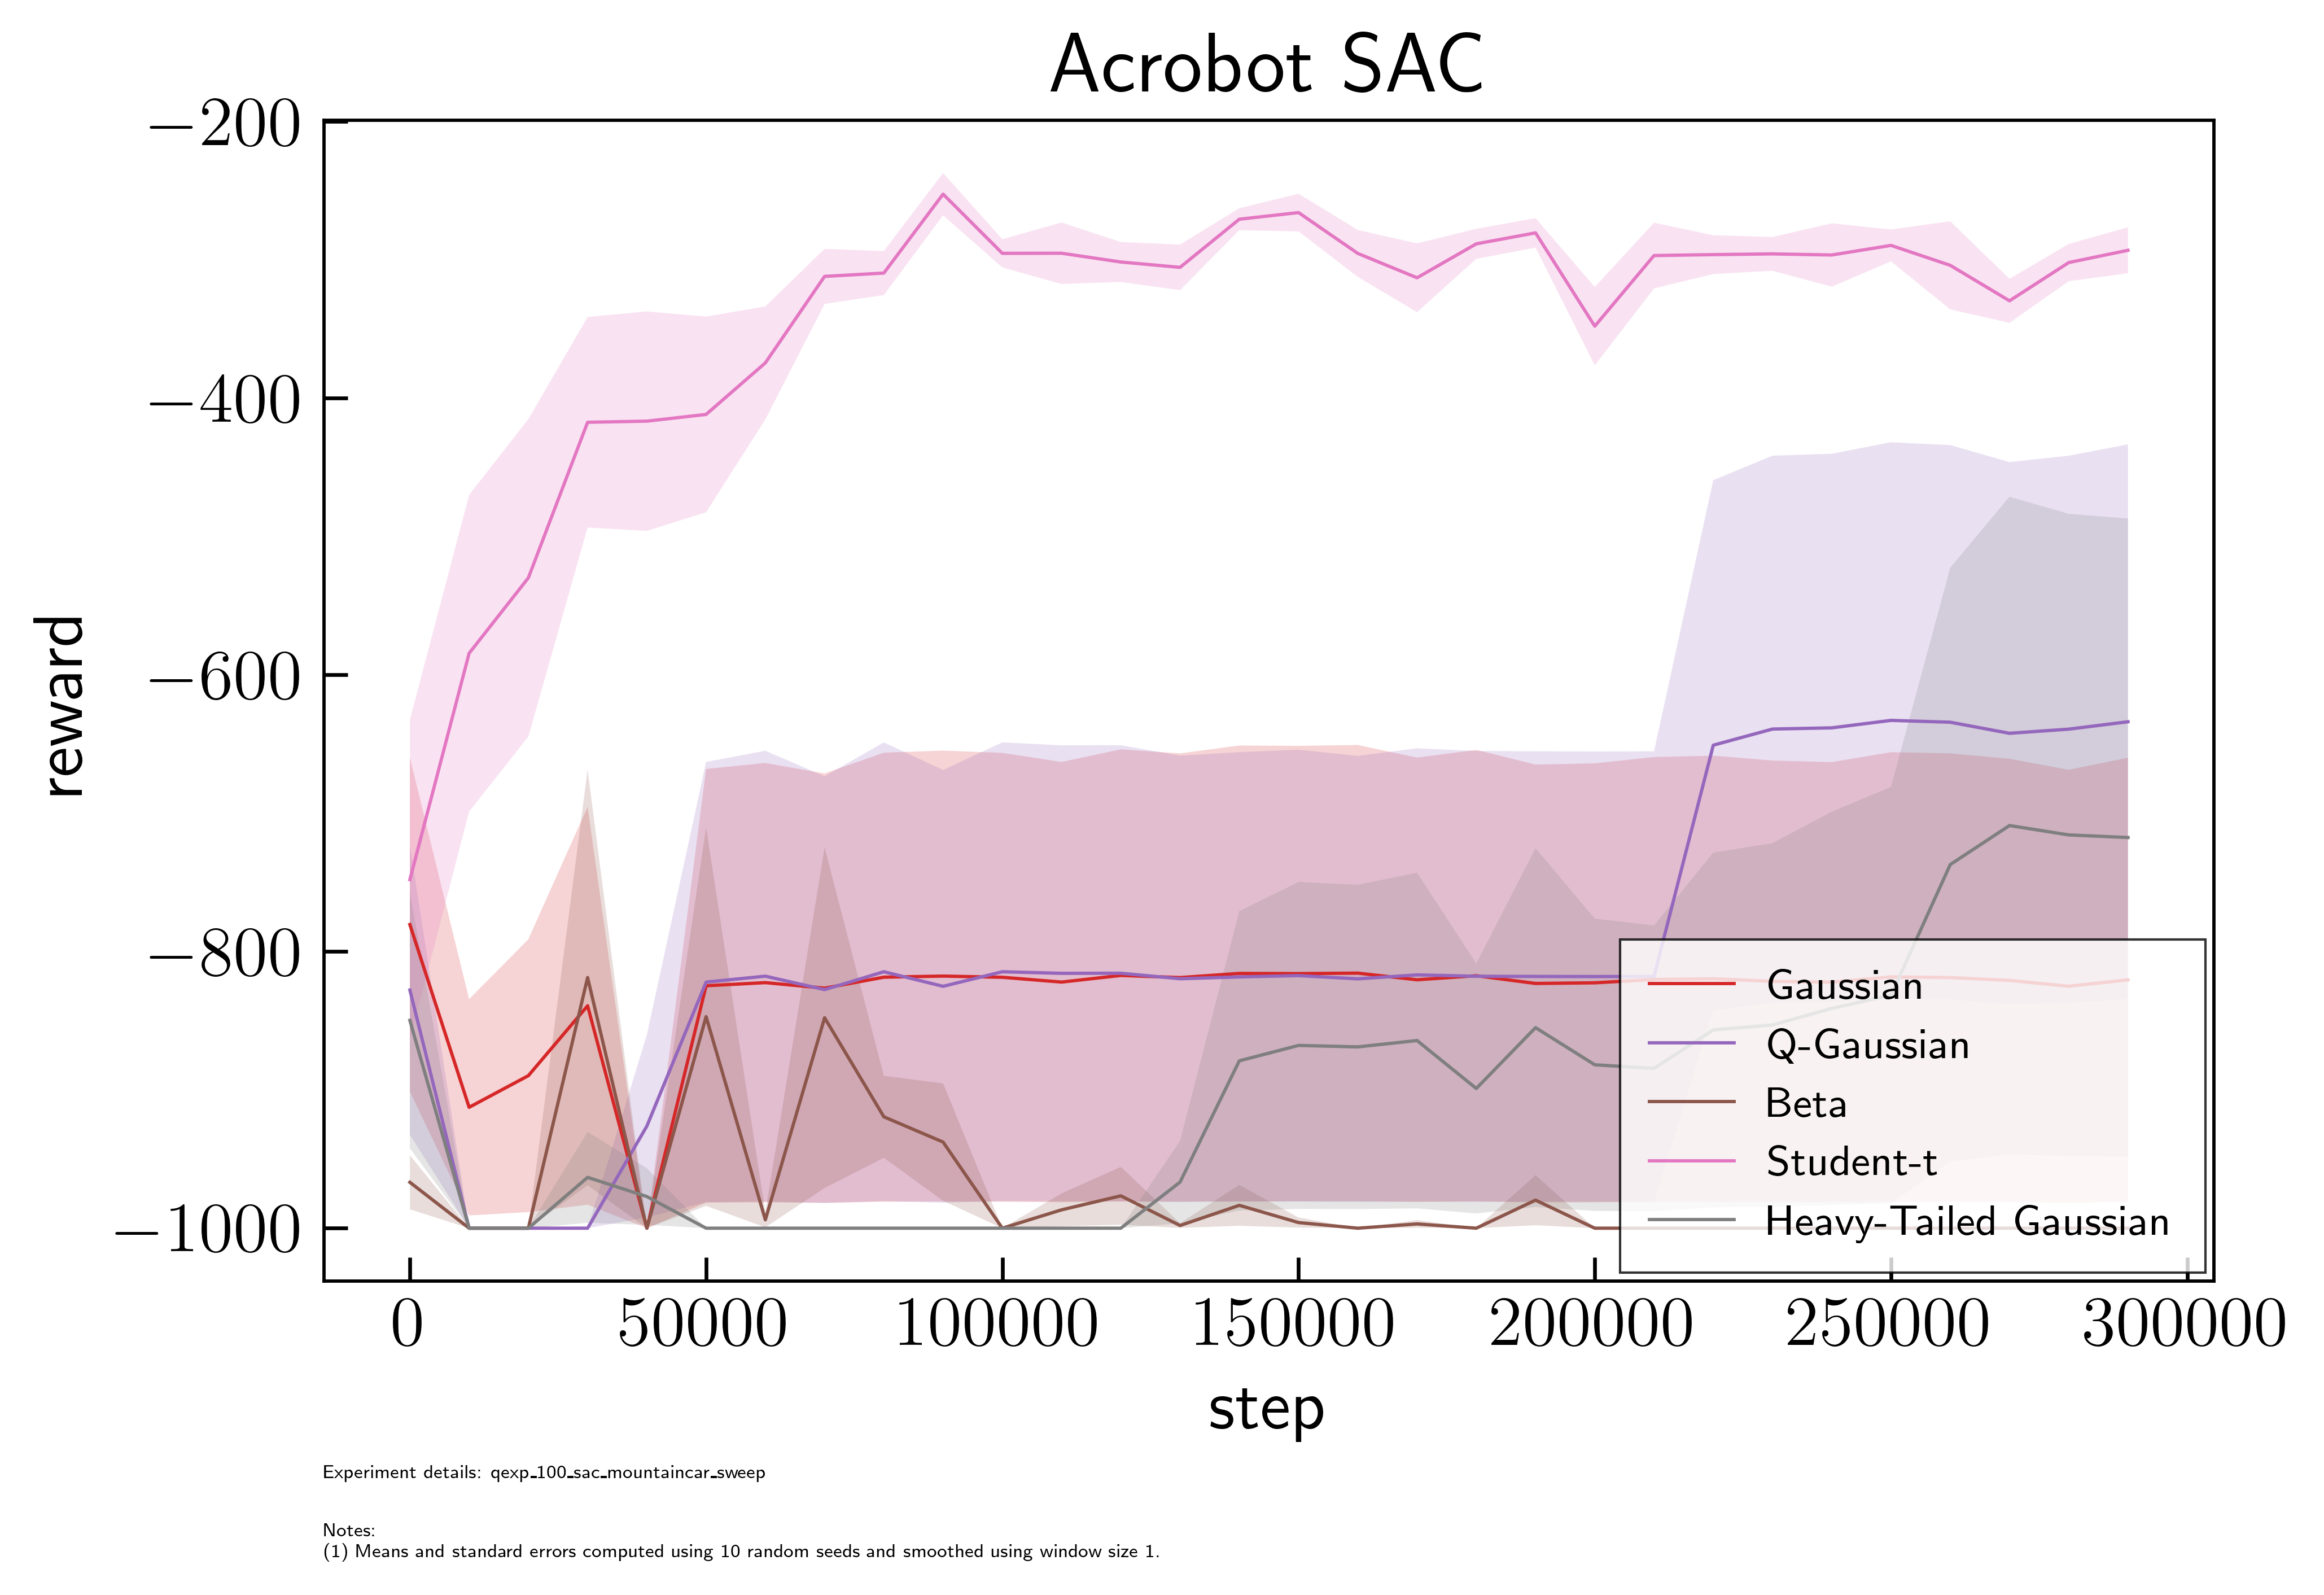

In [11]:
fig, ax = plt.subplots(figsize=(7.2, 4.45), dpi=600)
#plt.figure(figsize=(7.2/2, 4.45/2), dpi=300)
plt.title("Acrobot SAC")
plt.xlabel("step")
plt.ylabel(f'reward')
seeds = range(0,10)
moving_avg_window_size = 1
individual_moving_avg_window_size = 1


#plt.ylim(bottom=-1.25,top=0)
#plt.xlim(-100, 1000)
step_increment = 10
xlim = 100000
xlim = int(xlim / step_increment)
lwidth = 0.7
individual_curves_alpha = 0.15
nseeds=10

color_idx = 0
color_idx += 1
color_idx += 1
color_idx += 1
db = db1
print(best_p := conditions_to_str(gaussian))
v = db.q(f'select step, avg(reward), std(reward)/sqrt(count(*)), count(*) from runs join returns where returns.run = runs.run and {best_p} group by step limit {xlim}').values
mean = moving_avg(v[:,1],moving_avg_window_size) #test
std_err = moving_avg(v[:,2],moving_avg_window_size)
plt.plot(v[:,0], mean, color=colors[color_idx], linewidth=lwidth, linestyle='-', label=r'Gaussian')
plt.fill_between(v[:,0], mean+std_err, mean-std_err, alpha=0.2, color=colors[color_idx], edgecolor=None )

color_idx += 1
db = db1
print(best_p := conditions_to_str(q_gaussian))
v = db.q(f'select step, avg(reward), std(reward)/sqrt(count(*)), count(*) from runs join returns where returns.run = runs.run and {best_p} group by step limit {xlim}').values
mean = moving_avg(v[:,1],moving_avg_window_size) #test
std_err = moving_avg(v[:,2],moving_avg_window_size)
plt.plot(v[:,0], mean, color=colors[color_idx], linewidth=lwidth, linestyle='-', label=r'Q-Gaussian')
plt.fill_between(v[:,0], mean+std_err, mean-std_err, alpha=0.2, color=colors[color_idx], edgecolor=None )


color_idx += 1
db = db1
print(best_p := conditions_to_str(beta))
v = db.q(f'select step, avg(reward), std(reward)/sqrt(count(*)), count(*) from runs join returns where returns.run = runs.run and {best_p} group by step limit {xlim}').values
mean = moving_avg(v[:,1],moving_avg_window_size) #test
std_err = moving_avg(v[:,2],moving_avg_window_size)
plt.plot(v[:,0], mean, color=colors[color_idx], linewidth=lwidth, linestyle='-', label=r'Beta')
plt.fill_between(v[:,0], mean+std_err, mean-std_err, alpha=0.2, color=colors[color_idx], edgecolor=None )


color_idx += 1
db = db1
print(best_p := conditions_to_str(student))
v = db.q(f'select step, avg(reward), std(reward)/sqrt(count(*)), count(*) from runs join returns where returns.run = runs.run and {best_p} group by step limit {xlim}').values
mean = moving_avg(v[:,1],moving_avg_window_size) #test
std_err = moving_avg(v[:,2],moving_avg_window_size)
plt.plot(v[:,0], mean, color=colors[color_idx], linewidth=lwidth, linestyle='-', label=r'Student-t')
plt.fill_between(v[:,0], mean+std_err, mean-std_err, alpha=0.2, color=colors[color_idx], edgecolor=None )


color_idx += 1
db = db1
print(best_p := conditions_to_str(heavytail))
v = db.q(f'select step, avg(reward), std(reward)/sqrt(count(*)), count(*) from runs join returns where returns.run = runs.run and {best_p} group by step limit {xlim}').values
mean = moving_avg(v[:,1],moving_avg_window_size) #test
std_err = moving_avg(v[:,2],moving_avg_window_size)
plt.plot(v[:,0], mean, color=colors[color_idx], linewidth=lwidth, linestyle='-', label=r'Heavy-Tailed Gaussian')
plt.fill_between(v[:,0], mean+std_err, mean-std_err, alpha=0.2, color=colors[color_idx], edgecolor=None )




handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend = plt.legend(by_label.values(), by_label.keys(), prop={'size': 9}, loc=4)

frame = legend.get_frame()

frame.set_linewidth(0.5)
frame.set_edgecolor('black')

frame.set_boxstyle('Square')

...



notes = f'Experiment details: qexp_100_sac_mountaincar_sweep \n ' \
+f'\n\n Notes: \n\t\t (1) Means and standard errors computed using {nseeds} random seeds and smoothed using window size {moving_avg_window_size}. '
ax.annotate(notes,
            xy = (0.0, -0.2),
            xycoords='axes fraction',
            ha='left',
            va="center",
            fontsize=4)

#plt.savefig('figures/0022_plt.svg', bbox_inches='tight', transparent=False)
plt.savefig('figures/115.png', bbox_inches='tight', transparent=False)


## plot best